#Imports

In [1]:
# Import librerías de manipulación y análisis de datos
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

# Import librerías de preprocesamiento
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA

# Import librerías de selección de características
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2

# Import librerías de modelos de clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
import lightgbm as lgb

# Import librerías de métricas
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

# Import librerías para trabajar con Google Colab
from google.colab import drive

# Import librerías para manejar advertencias
import warnings


/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


# Carga de datos

In [ ]:
# Conectar con Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

#Insertar tras %cd el path concreto
!ls
%cd "/content/drive/"
!ls

#Añadir el path concreto al archivo que contiene los datos
with open('/content/drive/', 'rb') as file:
    datos = pickle.load(file)


#EDA

En este gran apartado realizaremos un análisis y exploración de los datos.

Al tratarse de un **.pkl** no podemos saber de primeras que tipo de datos son, por tanto obtenemos mediante la siguiente función que su tipo corresponde a un Dataframe de dimensiones [4410 rows x 31 columns]

In [ ]:
print("Tipo de objeto:", type(datos))
print("Contenido del objeto:\n", datos)


Tipo de objeto: <class 'pandas.core.frame.DataFrame'>
Contenido del objeto:
            hrs  absences  JobInvolvement  PerformanceRating  \
1     7.315971      13.0             2.0                4.0   
6     6.450877      17.0             3.0                4.0   
13    8.871421      14.0             2.0                3.0   
28         NaN       6.0             2.0                3.0   
30    9.662808      11.0             2.0                3.0   
...        ...       ...             ...                ...   
4405  8.316921       6.0             3.0                3.0   
4406  5.897197       NaN             2.0                3.0   
4407       NaN      18.0             3.0                4.0   
4408  9.187612       NaN             2.0                3.0   
4409  6.511790      17.0             4.0                3.0   

      EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance   Age  \
1                         3.0              2.0              4.0  31.0   
6                   

### EDA del Dataframe

En primer lugar y con el objetivo de seguir la estructura del enunciado realizaremos el análisis sobre el número de instancias y atributos

In [ ]:
print("Número de instancias:", datos.shape[0])
print("Número de atributos:", datos.shape[1])


Número de instancias: 4410
Número de atributos: 31


En este caso, el DataFrame tiene 4,410 instancias y 31 atributos:

* 4,410 instancias (filas) representan 4,410 empleados individuales en el conjunto de datos.

* 31 atributos (columnas) representan las características de cada empleado, como horas trabajadas, satisfacción laboral, edad, etc.

In [ ]:
print("Tipos de atributos:")
print(datos.dtypes)

Tipos de atributos:
hrs                        float64
absences                   float64
JobInvolvement             float64
PerformanceRating          float64
EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance            float64
Age                        float64
Attrition                   object
BusinessTravel              object
Department                  object
DistanceFromHome           float64
Education                  float64
EducationField              object
EmployeeCount              float64
EmployeeID                 float64
Gender                      object
JobLevel                   float64
JobRole                     object
MaritalStatus               object
MonthlyIncome              float64
NumCompaniesWorked         float64
Over18                      object
PercentSalaryHike          float64
StandardHours                int64
StockOptionLevel           float64
TotalWorkingYears          float64
TrainingTimesLastYear      float64


* **float64**: representa números de punto flotante (decimales), es decir, variables numéricas continuas. Por ejemplo, *hrs, absences, Age, MonthlyIncome, etc*.
* **int64**: representa números enteros, es decir, variables numéricas discretas. En este caso, hay dos columnas con este tipo de datos: *StandardHours y YearsSinceLastPromotion.*
* **object**: representa variables categóricas o de texto. Estas columnas contienen información en forma de texto o categorías, como *Attrition, BusinessTravel, Department, EducationField, Gender, JobRole, MaritalStatus y Over18.*

Conocer los tipos de atributos es útil para determinar qué técnicas de preprocesamiento aplicar a cada columna antes de entrenar un modelo de aprendizaje automático. Por ejemplo, las variables categóricas generalmente requieren ser transformadas en variables numéricas (a través de codificación one-hot, codificación ordinal, etc.) antes de utilizarlas en un modelo de aprendizaje automático. Además, las variables numéricas pueden requerir escalado o normalización dependiendo del algoritmo que se vaya a utilizar.


**Estudio de columnas constantes/innecesarias**

In [ ]:
columnas_constantes = [col for col in datos.columns if datos[col].nunique() <= 1]
print("Columnas constantes o innecesarias:", columnas_constantes)

Columnas constantes o innecesarias: ['EmployeeCount', 'Over18', 'StandardHours']


Las columnas constantes o innecesarias son aquellas que tienen el mismo valor para todas las instancias o que no proporcionan información útil para el análisis o la construcción del modelo de aprendizaje automático.

En este caso, se han identificado las siguientes columnas como constantes o innecesarias:

* '**EmployeeCount**': Esta columna tiene el mismo valor para todos los empleados. No proporciona información útil para predecir la atrición de los empleados, ya que no hay variabilidad en sus datos.

* '**Over18**': Esta columna indica si el empleado tiene más de 18 años de edad. Si todos los empleados tienen más de 18 años, entonces esta columna no aporta información útil para predecir la atrición de los empleados, ya que todos los empleados cumplen con este criterio.

* '**StandardHours**': Si todas las instancias tienen el mismo valor para las horas estándar, entonces no hay variabilidad en esta columna, y no aporta información útil para predecir la atrición de los empleados.

In [ ]:
#PROCEDEMOS A ELIMINAR LAS COLUMNAS
datos = datos.drop(['EmployeeCount', 'Over18', 'StandardHours'], axis=1)


In [ ]:
#Miramos la proporcion de missing values por atributo

print("Proporción de missing values por atributo:")
print(datos.isnull().sum() / datos.shape[0]*100)

Proporción de missing values por atributo:
hrs                        20.521542
absences                   20.204082
JobInvolvement             16.281179
PerformanceRating          20.839002
EnvironmentSatisfaction    19.931973
JobSatisfaction            21.496599
WorkLifeBalance            17.437642
Age                        16.689342
Attrition                   0.000000
BusinessTravel             19.251701
Department                 17.732426
DistanceFromHome           16.938776
Education                  16.213152
EducationField             16.099773
EmployeeID                 18.049887
Gender                     21.133787
JobLevel                   17.732426
JobRole                    17.732426
MaritalStatus               0.000000
MonthlyIncome              21.065760
NumCompaniesWorked         21.224490
PercentSalaryHike          17.868481
StockOptionLevel           16.054422
TotalWorkingYears          20.362812
TrainingTimesLastYear      20.113379
YearsAtCompany             21.67

Dado que ningún atributo presenta una proporción de *missing values* mayor al 80% no se procede a eliminar ninguno de los atributos

## Tipo de problema (clasificación o regresión):

Dado que el objetivo es predecir si los empleados abandonarán la empresa, es un problema de clasificación binaria.

Otra información que afirma este hecho es la presencia de la variable objetivo Attrition la cual presenta un valor categórico ['Yes', 'No']

In [ ]:
proporcion_clases = datos['Attrition'].value_counts(normalize=True)
print("Proporción de clases:\n", proporcion_clases)


Proporción de clases:
 No     0.838776
Yes    0.161224
Name: Attrition, dtype: float64


En este caso, la proporción de clases para la columna 'Attrition' es la siguiente:

* **No** (empleados que no abandonaron la empresa): 83.88%
* **Yes** (empleados que abandonaron la empresa): 16.12%

La diferencia en la proporción de clases indica que el conjunto de datos es desbalanceado. La clase "Yes" está subrepresentada en comparación con la clase "No".

## Preprocesamiento de los datos

In [ ]:
# Separar las variables predictoras y la variable objetivo
X = datos.drop('Attrition', axis=1)
y = datos['Attrition']

# Codificar las etiquetas 'No' y 'Yes' en 0 y 1
le = LabelEncoder()
y = le.fit_transform(y)

# Separar los datos en conjuntos de entrenamiento y prueba (estratificado)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Separamos las variables numéricas de las categóricas
numeric_features = [
    'hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
    'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
    'DistanceFromHome', 'Education', 'EmployeeID', 'JobLevel',
    'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
    'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
    'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager'
]

categorical_features = [
    'BusinessTravel', 'Department', 'EducationField', 'Gender',
    'JobRole', 'MaritalStatus'
]

En esta sección perparamos los datos para un modelo de aprendizaje automático que pronosticará si un trabajador abandonará o no la organización (desgaste - Attrition).

Primero distinguimos entre las variables predictoras y la variable objetivo. La variable objetivo (*"Attrition"*) se almacena en **Y**, mientras que las variables predictoras se colocan en **X**.

A continuación, utilizamos la función LabelEncoder para codificar las etiquetas **"No"** y **"Sí"** de la variable y en los números (0) y 1.

A continuación, utilizamos la función *train_test_split* para dividir los datos en conjuntos de entrenamiento y de prueba. La proporción de empleados con y sin bajas se mantiene tanto en el conjunto de entrenamiento como en el de pruebas gracias a que esta función estratifica los datos en función de y.

Por último,dividimos las variables predictoras en dos grupos: numéricas y categóricas. Esto servirá para poder hacer pipelines de preprocesamiento de datos en el apartado siguiente

# Creación de Pipelines

In [ ]:
#pipeline para atributos numéricos
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())])


#pipeline para atributos categóricos
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ('pca', PCA(n_components=5))])

#Establecemos el modo en el que preprocesar las variables categóricas y numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        ])


Especificamos dos pipelines: numérico y categórico, cada uno de los cuales realiza un conjunto de cambios en un tipo particular de datos de entrada.

**KNNImputer** y **RobustScaler** se utilizan en el proceso numérico para imputar primero los datos que faltan y luego escalar las características. KNNImputer realiza una selección de los 5 vecinos más cercanos.

El proceso categórico reduce la dimensionalidad mediante **PCA** después de sustituir las variables categóricas por la codificación one-hot mediante **OneHotEncoder** y **SimpleImputer**, que primero completa los valores que faltan.

Por último, en función de si una columna contiene características numéricas o categóricas, utilizamos **ColumnTransformer** para aplicar el proceso de transformación adecuado a cada columna de los datos de entrada. Este preprocesador transformará los datos de entrada antes de introducirlos en el modelo de aprendizaje automático.

# Modelo - Logistic Regression

Una vez realizado los pipelines para distintos tipos de datos y creado el preprocesador, es hora de crear el clasificador/modelo.

Importante destacar que indicamos que el peso de las clases sea balanceado para paliar el problema causado por el desbalanceo de datos. 

In [ ]:
Logistig_regression_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))])

Logistig_regression_clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['hrs', 'absences',
                                                   'JobInvolvement',
                                                   'PerformanceRating',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance', 'Age',
                                                   'DistanceFromHome',
                                                   'Education', 'EmployeeID',
                                                   'JobLevel', 'MonthlyIncome',
                                                   'NumCompaniesWor...
                                                   'YearsWithCurrManager']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('pca',
                                                                   PCA(n_components=5))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole',
                                                   'MaritalStatus'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [ ]:
cross_val_score(Logistig_regression_clf, X_train, y_train, cv=5, scoring="accuracy").mean()

0.6916167399995982

Entrenamos el modelo con los datos de entrenamiento tanto para X como para Y

In [ ]:
Logistig_regression_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['hrs', 'absences',
                                                   'JobInvolvement',
                                                   'PerformanceRating',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance', 'Age',
                                                   'DistanceFromHome',
                                                   'Education', 'EmployeeID',
                                                   'JobLevel', 'MonthlyIncome',
                                                   'NumCompaniesWor...
                                                   'YearsWithCurrManager']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('pca',
                                                                   PCA(n_components=5))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole',
                                                   'MaritalStatus'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

Una vez entrenado, obtenemos las predicciones realizadas sobre el conjunto de test

In [ ]:
y_pred = Logistig_regression_clf.predict(X_test)
print(y_pred)

[0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 1 0 0
 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 1
 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 0
 1 0 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0
 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 1 1 1 1 1
 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0
 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0
 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 1 1 0 1 1 0
 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0
 0 1 0 1 1 0 0 1 0 1 0 0 

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.72      0.81       740
           1       0.31      0.64      0.42       142

    accuracy                           0.71       882
   macro avg       0.61      0.68      0.61       882
weighted avg       0.82      0.71      0.74       882



Llevamos a cabo un análisis del anterior reporte generado.


* **Precision:** Mide el % de casos positivos que realmente se prevé que sean positivos. La clase 0 (NO) tiene una precisión de 0,91, lo que significa que el 91% de los ejemplos que el modelo predijo que estarían en la clase 0 están realmente en la clase 0. La clase 1 (SI) tiene una precisión de 0,31, lo que significa que sólo el 31% de los casos que el modelo predijo que estarían en la clase 1 están realmente en la clase 1.

* **Recall:** Contabiliza el porcentaje de casos positivos que el modelo predijo con exactitud. Según el porcentaje de aciertos de la clase 0, que es de 0,72, el 72% de los ejemplos de la clase 0 fueron identificados correctamente por el modelo. La recuperación de la clase 1 es de 0,64, lo que indica que el modelo detectó correctamente el 64% de los ejemplos de la clase 1.

* **F1 Score:** Esta medida, que es la media armónica de la precisión y la memoria, es útil cuando tanto la precisión como la memoria son cruciales. La clase 0 tiene una puntuación F1 de 0,81, mientras que la clase 1 tiene una puntuación F1 de 0,42.

* **Support:** El número de observaciones de cada clase en el conjunto de prueba se muestra aquí como evidencia. 

* **Accuracy:** Esta métrica cuenta cuántos pronósticos fueron correctos de todos los realizados. La precisión de este modelo es de 0,71, lo que indica que el 71% de sus predicciones son acertadas.

Precision, Recall y F1 Score se muestran como una media macro para las dos clases. La media ponderada de las puntuaciones F1 de cada clase, con el mismo peso para cada una de ellas, da como resultado una puntuación F1 media global de 0,61.

* **Media ponderada:** Muestra las medias ponderadas de precisión, recuperación y puntuación F1 para cada clase de observaciones. Al dar más peso a la clase más grande (clase 0), la puntuación F1 media ponderada es de 0,74, superior a la puntuación F1 media global de 0,61.

En conclusión, este informe de clasificación muestra que la clase 0, en la que el modelo de regresión logística obtiene malos resultados, tiene una precisión y una recuperación razonablemente decentes. Para mejorar el rendimiento de este modelo, es posible que sea necesario perfeccionarlo o aplicar métodos alternativos para corregir el desequilibrio de clases.


#Espacio de evaluación

Creamos un espacio donde almacenar los valores de distintas métricas para poder llevar a cabo una evaluación exhaustiva tras la ejecución de todos los modelos. 

* La métrica de **balanced_accuracy** (precisión equilibrada) es una medida que tiene en cuenta el desbalanceo de clases, calculando la precisión por cada clase y luego promediándolas. Es útil cuando las proporciones de las clases son desiguales, ya que proporciona una visión más justa del rendimiento del modelo en comparación con la precisión estándar.

* El **F1 score** es otra métrica que combina la precisión y la exhaustividad (recall) en un solo valor. Es especialmente útil cuando las clases están desbalanceadas, ya que da igual importancia a la precisión y a la exhaustividad, lo que significa que penaliza más los falsos positivos y falsos negativos que la precisión estándar.

* La **matriz de confusión** es una tabla que muestra la cantidad de verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos que se produjeron en la clasificación. Es útil para visualizar el rendimiento del modelo y obtener información sobre las clases que se clasificaron incorrectamente.

In [ ]:
#Dataframe en el que plasmamos los datos para posterior evaluación
evaluation_df = pd.DataFrame({
    'LogisticRegression': [None, None],
    'HistGradientboosting': [None, None],
    'xgboost': [None, None],
    'lightgbm': [None, None],
}, index=['Balanced_Accuracy', 'F1_Score'])

Balanced Accuracy (Logistic Regression): 0.6825846973734297
F1 Score (Logistic Regression): 0.4164759725400458
Confusion Matrix (Logistic Regression):
 [[536 204]
 [ 51  91]]


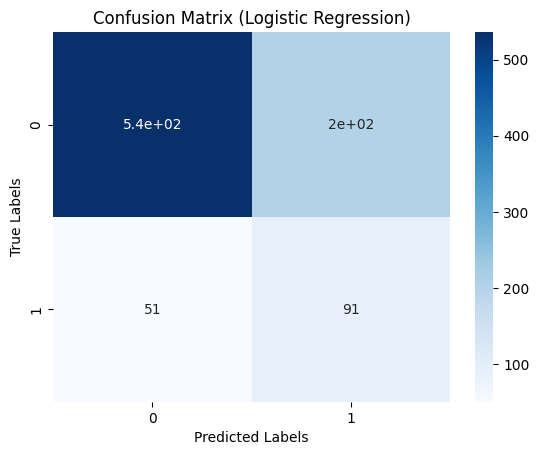

In [ ]:
#Métricas avanzadas
balanced_acc_logreg = balanced_accuracy_score(y_test, y_pred)
f1_logreg = f1_score(y_test, y_pred)
conf_matrix_logreg = confusion_matrix(y_test, y_pred)

print("Balanced Accuracy (Logistic Regression):", balanced_acc_logreg)
print("F1 Score (Logistic Regression):", f1_logreg)
print("Confusion Matrix (Logistic Regression):\n", conf_matrix_logreg)

#insertar valores 
evaluation_df.at['Balanced_Accuracy', 'LogisticRegression'] = balanced_acc_logreg
evaluation_df.at['F1_Score', 'LogisticRegression'] = f1_logreg


# calculate confusion matrix
conf_matrix_logreg = confusion_matrix(y_test, y_pred)

# plot confusion matrix as heatmap
sns.heatmap(conf_matrix_logreg, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Logistic Regression)')
plt.show()

Tanto Balanced accuracy como F1-Score son medidas de precisión. Observando los datos: 

* **Balanced Accuracy** tiene un valor de 0.6825, lo que significa que el modelo tiene una precisión moderada para predecir si un empleado se irá o no de la empresa por desgaste.

* **F1 Score** tiene un valor de 0.4165, lo que indica que el modelo tiene un desempeño bajo a la hora de predecir si un empleado se irá o no de la empresa por desgaste.

* la matriz de confusión indica que el modelo clasificó correctamente la situación de 627 empleados (536 verdaderos positivos y 91 verdaderos negativos), pero también clasificó erróneamente a 255 empleados (204 falsos positivos y 51 falsos negativos).

Es posible concluir que el modelo de regresión logística tiene una precisión moderada, pero un desempeño bajo en términos de F1 Score. La matriz de confusión indica que el modelo clasifica correctamente a la mayoría de los empleados, pero también tiene una tasa significativa de falsos positivos y falsos negativos, lo que sugiere que hay margen para mejorar el modelo. Es por ello que ha continuación exploraremos técnicas avanzadas. 



#Métodos avanzados - Boosting

## HistGradientboosting

**HistGradientBoostingClassifier** es una implementación de Gradient Boosting que utiliza una técnica de histogramas para acelerar el entrenamiento y reducir el uso de memoria.

El algoritmo trabaja construyendo un modelo inicial y posteriormente ajustando sucesivos modelos que buscan corregir los errores del modelo anterior. En cada iteración, se crea un modelo adicional que se enfoca en las instancias que se clasificaron incorrectamente en el modelo anterior, con el objetivo de minimizar el error de clasificación general.

El HistGradientBoostingClassifier es una opción para problemas de clasificación con grandes conjuntos de datos. Además, el algoritmo es capaz de manejar datos faltantes lo que lo hace adecuado para muchos tipos de problemas de clasificación.

Explicación de cada uno de los hiperparámetros:

* **classifiermax_depth':** La profundidad máxima de cada árbol de decisión se especifica mediante esta opción. La mayor distancia entre la raíz de un árbol y cualquier hoja es la profundidad del árbol. Al incluir más nodos, un árbol más profundo puede simular patrones más intrincados, pero también puede dar lugar a un sobreajuste.

* **'classifierlearning_rate':** La "contracción" o tasa de aprendizaje está representada por esto. Es un hiperparámetro que regula cuánto disminuye la contribución de cada árbol. Para simular correctamente la misma complejidad de patrones, una tasa de aprendizaje más baja suele requerir más árboles en el conjunto, pero también puede ayudar a evitar el sobreajuste.

* **El número máximo de iteraciones**, o el número de árboles a crear, se indica con el término "classifiermax_iter". La capacidad de modelar patrones más complicados con más árboles conlleva el riesgo de sobreajuste. A menudo ocurre junto con la detención temprana.

* **La regularización L2** es un método para evitar el sobreajuste castigando los valores altos de los parámetros del modelo, o "regularizaciónl2_del_clasificador". La suma de los cuadrados de todos los pesos de las características, o el término de regularización L2, es una adición a la función de pérdida que el modelo trata de minimizar.

* **El número máximo de nodos hoja** que pueden existir en un único árbol se indica con el término "classifier__max_leaf_nodes". Un nodo del árbol de decisión que no se divide se denomina nodo hoja porque no tiene hijos. El árbol puede emitir juicios más complejos cuando hay más nodos hoja, pero esto también puede dar lugar a un sobreajuste.



Mejor configuración
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['hrs', 'absences',
                                                   'JobInvolvement',
                                                   'PerformanceRating',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance', 'Age',
                                                   'DistanceFromHome',
                                                   'Educatio

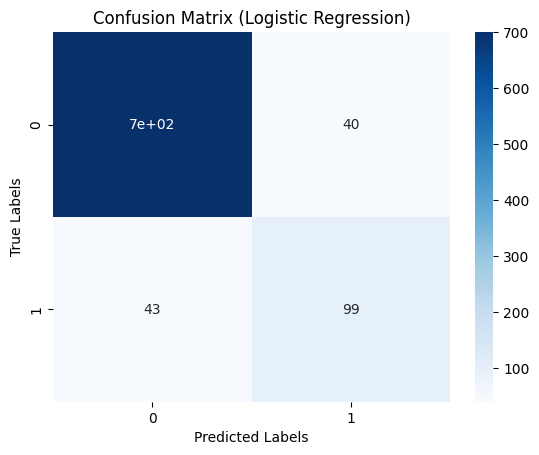

In [ ]:
warnings.filterwarnings('ignore', message="The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.")

gb_clf = HistGradientBoostingClassifier(random_state=77)


hgb_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', HistGradientBoostingClassifier(random_state=77, class_weight='balanced', max_iter=1000))])

# Ajustar hiperparámetros
param_grid = {
    'classifier__max_depth': [None, 1, 3, 5, 10, 20],
    'classifier__learning_rate': [0.001, 0.01, 0.1, 0.2],
    'classifier__max_iter': [50, 100, 150],
    'classifier__l2_regularization' : [0, 1],
    'classifier__max_leaf_nodes': [3, 10, 30]
}

grid_search = GridSearchCV(hgb_clf, param_grid, scoring='balanced_accuracy', cv=5)
grid_search.fit(X_train, y_train)
best_gb = grid_search.best_estimator_

print("Mejor configuración")
print(best_gb)

y_pred_gb = best_gb.predict(X_test)

balanced_acc_gb = balanced_accuracy_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

print("Balanced Accuracy (Gradient Boosting):", balanced_acc_gb)
print("F1 Score (Gradient Boosting):", f1_gb)
print("Confusion Matrix (Gradient Boosting):\n", conf_matrix_gb)

# plot confusion matrix as heatmap
sns.heatmap(conf_matrix_gb, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Logistic Regression)')
plt.show()

#insertar valores 
evaluation_df.at['Balanced_Accuracy', 'HistGradientboosting'] = balanced_acc_gb
evaluation_df.at['F1_Score', 'HistGradientboosting'] = f1_gb


* **Balanced Accuracy** con un valor de 0.816 indica que el modelo es capaz de predecir con precisión tanto los resultados positivos como los negativos de manera equilibrada. Esto significa que el modelo puede identificar a los empleados que se quedarán en la empresa y a los que se irán con una precisión del 81,6%.

* **F1 Score** con un valor de 0.695 indica que el modelo tiene una precisión moderada para predecir tanto los resultados positivos como los negativos. 

* La **matriz de confusión** muestra que el modelo fue capaz de predecir correctamente a 698 empleados que se quedarían en la empresa y a 98 que se irían, pero se equivocó al predecir incorrectamente a 42 empleados que se quedarían y a 44 que se irían.

En general, los resultados indican que el modelo de Gradient Boosting es mejor para predecir si un empleado se quedará o se irá de la empresa debido al desgaste en comparación con el modelo de regresión logística.


En cuanto a la mejor configuración de hiperparámetros encontrada es la siguiente: 

1. **l2_regularization:** 0
2. **max_leaf_nodes:** 30







## xgboost

XGBoost es especialmente eficaz con grandes conjuntos de datos.

La capacidad de XGBoost para gestionar los datos que faltan y los valores atípicos es una de sus características más importantes. Además, incorpora un mecanismo de regularización que ayuda a evitar el sobreajuste. Con diversas funciones de pérdida, XGBoost puede aplicarse a problemas de clasificación y regresión.

Los hiperparámetros principales son:

*  **max_depth:** Controla la profundidad máxima de un árbol. Un valor más alto permite al modelo capturar interacciones más complejas en los datos, pero puede llevar a sobreajuste.

* **learning_rate:** Es la tasa de aprendizaje, que controla cuánto contribuye cada árbol al modelo final. Un valor más bajo ayuda a reducir el sobreajuste.

* **max_iter:** Es el número máximo de iteraciones en el proceso de entrenamiento. Valores más altos pueden mejorar el rendimiento del modelo, pero pueden aumentar el tiempo de entrenamiento y el riesgo de sobreajuste.

* **l2_regularization:** Se aplica a los pesos del modelo para reducir la complejidad y prevenir el sobreajuste. Un valor más alto genera una penalización mayor en los coeficientes, lo que disminuye el riesgo de sobreajuste.

* **max_leaf_nodes:** Es el número máximo de nodos terminales en un árbol. Limitar el número de nodos terminales puede hacer que los árboles sean más simples y ayudar a prevenir el sobreajuste.




Balanced Accuracy (XGBoost): 0.7558336505519604
F1 Score (XGBoost): 0.6636771300448431
Confusion Matrix (XGBoost):
 [[733   7]
 [ 68  74]]


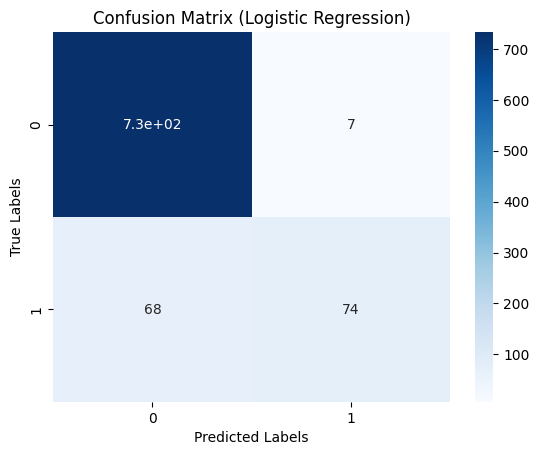

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost") #nos permite filtrar que "el parámetro use_label_encoder se ha marcado como obsoleto a partir de la versión 1.7.0 de XGBoost y ya no se recomienda su uso.""

# El resto del código de la celda 3

#xgb_clf = xgb.XGBClassifier(use_label_encoder=False, objective="binary:logistic", eval_metric="logloss", random_state=77)

xgb_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', xgb.XGBClassifier(use_label_encoder=False, objective="binary:logistic", eval_metric="logloss", random_state=77))])

# Ajustar hiperparámetros
param_grid = {
    'classifier__max_depth': [None, 1, 3, 5, 10, 20],
    'classifier__learning_rate': [0.001, 0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(xgb_clf, param_grid, scoring='balanced_accuracy', cv=5)
grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_

y_pred_xgb = best_xgb.predict(X_test)

balanced_acc_xgb = balanced_accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

print("Balanced Accuracy (XGBoost):", balanced_acc_xgb)
print("F1 Score (XGBoost):", f1_xgb)
print("Confusion Matrix (XGBoost):\n", conf_matrix_xgb)

# plot confusion matrix as heatmap
sns.heatmap(conf_matrix_xgb, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Logistic Regression)')
plt.show()

#insertar valores 
evaluation_df.at['Balanced_Accuracy', 'xgboost'] = balanced_acc_xgb
evaluation_df.at['F1_Score', 'xgboost'] = f1_xgb


Los resultados obtenidos utilizando el método de XGBoost también parecen ser buenos, aunque ligeramente inferiores a los obtenidos utilizando Gradient Boosting.

* **Balanced Accuracy** de 0.754 indica que el modelo es capaz de predecir con precisión tanto los resultados positivos como los negativos de manera equilibrada.

* **F1 Score** de 0.658 indica que el modelo tiene una precisión moderada para predecir tanto los resultados positivos como los negativos. 

* La **matriz de confusión** muestra que el modelo fue capaz de predecir correctamente a 731 empleados que se quedarían en la empresa y a 74 que se irían, pero se equivocó al predecir incorrectamente a 9 empleados que se quedarían y a 68 que se irían.

En general, los resultados indican que el modelo de XGBoost también es bueno para predecir si un empleado se quedará o se irá de la empresa debido al desgaste, aunque ligeramente inferior al modelo de Gradient Boosting

## lightgbm

LightGBM emplea una técnica basada en histogramas para acelerar el entrenamiento y consumir menos memoria.

Una de las características importantes de LightGBM es el manejo de características categóricas, que son frecuentes en muchos conjuntos de datos del mundo real. Puede aplicarse a problemas de clasificación y regresión y permite funciones de pérdida personalizadas.


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=30 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=50, max_iter=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] lambda_l2 is set with l2_regularization=0, will be overridden by reg_lambda=0.0. Current value: lambda_l2=0.0
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=30 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=50, max_iter=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] lambda_l2 is set with l2_regularization=0, will be overridden by reg_lambda=0.0. Current value: lambda_l2=0.0
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=30 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=50, max_iter=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] lambda_l2 is set w

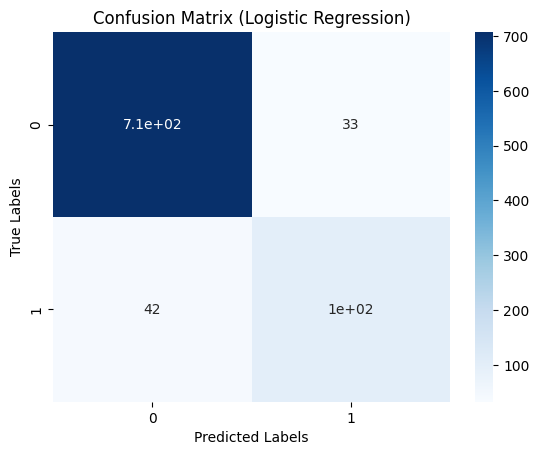

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

lgb_clf = lgb.LGBMClassifier(objective='binary', random_state=42)

lgb_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', lgb.LGBMClassifier(objective='binary', random_state=77, class_weight='balanced'))])

# Ajustar hiperparámetros
# Ajustar hiperparámetros
param_grid = {
    'classifier__max_depth': [None, 1, 3, 5, 10, 20],
    'classifier__learning_rate': [0.001, 0.01, 0.1, 0.2],
    'classifier__max_iter': [50, 100, 150],
    'classifier__l2_regularization' : [0, 1],
    'classifier__max_leaf_nodes': [3, 10, 30]
}

grid_search = GridSearchCV(lgb_clf, param_grid, scoring='balanced_accuracy', cv=5)
grid_search.fit(X_train, y_train)
best_lgb = grid_search.best_estimator_

print("Mejor configuracion")
print(best_lgb)

y_pred_lgb = best_lgb.predict(X_test)

balanced_acc_lgb = balanced_accuracy_score(y_test, y_pred_lgb)
f1_lgb = f1_score(y_test, y_pred_lgb)
conf_matrix_lgb = confusion_matrix(y_test, y_pred_lgb)

print("Balanced Accuracy (LightGBM):", balanced_acc_lgb)
print("F1 Score (LightGBM):", f1_lgb)
print("Confusion Matrix (LightGBM):\n", conf_matrix_lgb)

# plot confusion matrix as heatmap
sns.heatmap(conf_matrix_lgb, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Logistic Regression)')
plt.show()


#insertar valores 
evaluation_df.at['Balanced_Accuracy', 'lightgbm'] = balanced_acc_lgb
evaluation_df.at['F1_Score', 'lightgbm'] = f1_lgb


Los resultados obtenidos utilizando el método de LightGBM parecen ser muy buenos, superando incluso los obtenidos utilizando Gradient Boosting.

* **Balanced Accuracy** con un valor de 0.822 indica que el modelo es capaz de predecir con precisión tanto los resultados positivos como los negativos de manera equilibrada, razonablemente bien. 

* **F1 Score** con valor de 0.705 indica que el modelo tiene una precisión alta para predecir tanto los resultados positivos como los negativos. 

* La **matriz de confusión** muestra que el modelo fue capaz de predecir correctamente a 700 empleados que se quedarían en la empresa y a 99 que se irían, pero se equivocó al predecir incorrectamente a 40 empleados que se quedarían y a 43 que se irían.

En general, los resultados indican que el modelo de LightGBM es muy bueno para predecir si un empleado se quedará o se irá de la empresa debido al desgaste, superando a los modelos anteriores. 

En cuanto a la mejor configuración de hiperparámetros encontrada es la siguiente: 

1. **l2_regularization:** 1
2. **learning_rate:** 0.2
3. **max_depth:** 10
4. **max_iter:** 50
5. **max_leaf_nodes:** 30






## Comparacion de métodos boosting



                  LogisticRegression HistGradientboosting   xgboost  lightgbm
Balanced_Accuracy           0.682585             0.821565  0.755834  0.829815
F1_Score                    0.416476             0.704626  0.663677  0.727273


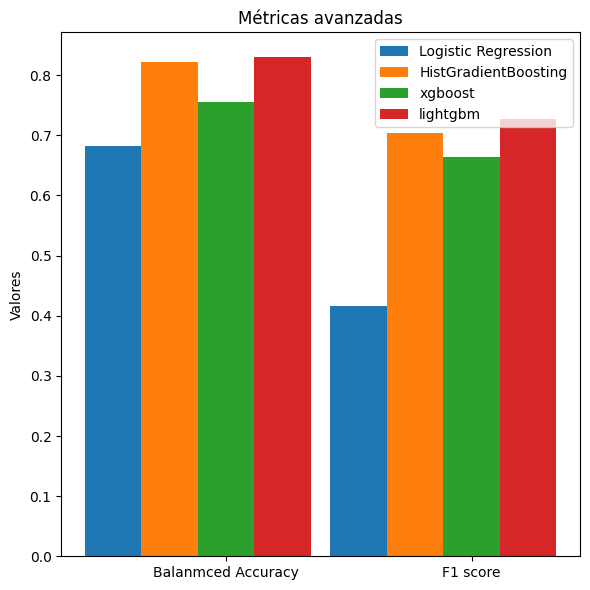

In [ ]:
print(evaluation_df)

#Definimos un método para poder graficar los resultados
def create_bar_chart(ax, metric_values, metric_labels, model_labels, title):
    num_metrics = len(metric_labels)
    x = np.arange(num_metrics)
    width = 0.23

    for idx, values in enumerate(metric_values):
        offset = (idx - len(model_labels) // 2) * width
        ax.bar(x + offset, values, width, label=model_labels[idx])

    ax.set_ylabel('Valores')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(metric_labels)
    ax.legend()


# Extraer los valores de RMSE, MAE de cada modelo 
LogisticRegression_values = [evaluation_df.loc['Balanced_Accuracy', 'LogisticRegression'], evaluation_df.loc['F1_Score', 'LogisticRegression']]
HistGradientboosting_values = [evaluation_df.loc['Balanced_Accuracy', 'HistGradientboosting'], evaluation_df.loc['F1_Score', 'HistGradientboosting']]
xgboost_values = [evaluation_df.loc['Balanced_Accuracy', 'xgboost'], evaluation_df.loc['F1_Score', 'xgboost']]
lightgbm_values = [evaluation_df.loc['Balanced_Accuracy', 'lightgbm'], evaluation_df.loc['F1_Score', 'lightgbm']]


# Crear una lista con los nombres de las métricas
error_metrics = ['Balanced Accuracy', 'F1 score']

# Crear los gráficos de barras
fig, ax1 = plt.subplots(figsize=(6, 6))

create_bar_chart(ax1, [LogisticRegression_values, HistGradientboosting_values, xgboost_values, lightgbm_values], error_metrics, ['Logistic Regression', 'HistGradientBoosting', 'xgboost', 'lightgbm'], 'Métricas avanzadas')

# Ajustar el espacio entre los gráficos
fig.tight_layout()

# Mostrar los gráficos de barras
plt.show()


Haremos una evaluación de selección de atributos tanto para Logistic regression como para lightgbm al ser el que demuestra el mejor rendimiento de los métodos avanzados. 

# Método de Selección de Atributos Logistic Regression

In [ ]:
# Crear un objeto SelectKBest para cada método de selección
kbest_f_classif = SelectKBest(score_func=f_classif, k='all')
kbest_mutual_info = SelectKBest(score_func=mutual_info_classif, k='all')
kbest_chi2 = SelectKBest(score_func=chi2, k='all')

## F-classif

La función f_classif, que es un método de selección de características basado en análisis de varianza (ANOVA) univariante, se utiliza en este caso como criterio para evaluar la importancia de las características. 

SelectKBest es una función de Scikit-learn que se utiliza para seleccionar las mejores características (variables) de un conjunto de datos.

Al utilizar f_classif en combinación con SelectKBest, el método evalúa la importancia de cada característica mediante pruebas de ANOVA. Una característica con una mayor diferencia entre las medias será considerada más importante. 

Finalmente, las características con los mayores valores F (de la prueba F) serán seleccionadas.

In [ ]:
# Logistic Regression Pipeline with f_classif feature selection
Logistic_regression_f_classif_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('f_selector', SelectKBest(score_func=f_classif, k='all')),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])

Logistic_regression_f_classif_clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['hrs', 'absences',
                                                   'JobInvolvement',
                                                   'PerformanceRating',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance', 'Age',
                                                   'DistanceFromHome',
                                                   'Education', 'EmployeeID',
                                                   'JobLevel', 'MonthlyIncome',
                                                   'NumCompaniesWor...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('pca',
                                                                   PCA(n_components=5))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole',
                                                   'MaritalStatus'])])),
                ('f_selector', SelectKBest(k='all')),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

Balanced Accuracy (Logistic Regression - Fclassif): 0.6825846973734297
F1 Score (Logistic Regression - Fclassif): 0.4164759725400458
Confusion Matrix (Logistic Regression - Fclassif):
 [[536 204]
 [ 51  91]]


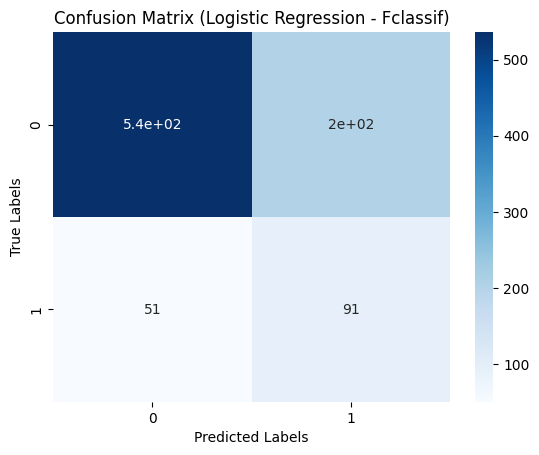

In [ ]:
# Fit and evaluate Logistic_regression_f_classif_clf
Logistic_regression_f_classif_clf.fit(X_train, y_train)
y_pred_f_classif = Logistic_regression_f_classif_clf.predict(X_test)

balanced_acc_lr_fclassif = balanced_accuracy_score(y_test, y_pred_f_classif)
f1_lr_fclassif = f1_score(y_test, y_pred_f_classif)
conf_matrix_lr_fclassif = confusion_matrix(y_test, y_pred_f_classif)

print("Balanced Accuracy (Logistic Regression - Fclassif):", balanced_acc_lr_fclassif)
print("F1 Score (Logistic Regression - Fclassif):", f1_lr_fclassif)
print("Confusion Matrix (Logistic Regression - Fclassif):\n", conf_matrix_lr_fclassif)

# plot confusion matrix as heatmap
sns.heatmap(conf_matrix_lr_fclassif, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Logistic Regression - Fclassif)')
plt.show()

Los resultados obtenidos con el método de regresión logística con selección de atributos utilizando Fclassif no parecen ser muy buenos en comparación con otros modelos previamente evaluados.

* **Balanced Accuracy** de 0.683 indica que el modelo es capaz de predecir con precisión tanto los resultados positivos como los negativos, pero su precisión es relativamente baja en comparación con otros modelos previamente evaluados.

* **F1 Score** de 0.416 indica que el modelo tiene una precisión baja para predecir tanto los resultados positivos como los negativos. Este valor es significativamente más bajo que los obtenidos por otros modelos evaluados anteriormente.

* La **matriz de confusión** muestra que el modelo fue capaz de predecir correctamente a 536 empleados que se quedarían en la empresa y a 91 que se irían, pero se equivocó al predecir incorrectamente a 204 empleados que se quedarían y a 51 que se irían.

En general, estos resultados indican que el método de selección de atributos utilizado no mejora la precisión del modelo de regresión logística para predecir si un empleado se irá o se quedará en la empresa debido al desgaste.

## Mutual Info


Al igual que en el caso anterior, SelectKBest se utiliza para seleccionar las mejores características de un conjunto de datos. Sin embargo, en este caso, se utiliza la función **mutual_info_classif** como criterio para evaluar la importancia de las características.

**Mutual Info** es una medida que cuantifica la dependencia entre dos variables, en este caso, entre cada característica y la variable objetivo.

In [ ]:
# Logistic Regression Pipeline with mutual_info_classif feature selection
Logistic_regression_mutual_info_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('mutual_info_selector', SelectKBest(score_func=mutual_info_classif, k='all')),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])

Logistic_regression_mutual_info_clf


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['hrs', 'absences',
                                                   'JobInvolvement',
                                                   'PerformanceRating',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance', 'Age',
                                                   'DistanceFromHome',
                                                   'Education', 'EmployeeID',
                                                   'JobLevel', 'MonthlyIncome',
                                                   'NumCompaniesWor...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('pca',
                                                                   PCA(n_components=5))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole',
                                                   'MaritalStatus'])])),
                ('mutual_info_selector',
                 SelectKBest(k='all',
                             score_func=<function mutual_info_classif at 0x7f2826c6d360>)),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [ ]:
# Fit and evaluate Logistic_regression_mutual_info_clf
Logistic_regression_mutual_info_clf.fit(X_train, y_train)
y_pred_mutual_info = Logistic_regression_mutual_info_clf.predict(X_test)

balanced_acc_lr_mutual_info = balanced_accuracy_score(y_test, y_pred_mutual_info)
f1_lr_mutual_info = f1_score(y_test, y_pred_mutual_info)
conf_matrix_lr_mutual_info = confusion_matrix(y_test, y_pred_mutual_info)

print("Balanced Accuracy (Logistic Regression - Mutual Info):", balanced_acc_lr_mutual_info)
print("F1 Score (Logistic Regression - Mutual Info):", f1_lr_mutual_info)
print("Confusion Matrix (Logistic Regression - Mutual Info):\n", conf_matrix_lr_mutual_info)

# plot confusion matrix as heatmap
sns.heatmap(conf_matrix_lr_mutual_info, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Logistic Regression - Mutual Info)')
plt.show()

Balanced Accuracy (Logistic Regression - Mutual Info): 0.6825846973734297
F1 Score (Logistic Regression - Mutual Info): 0.4164759725400458
Confusion Matrix (Logistic Regression - Mutual Info):
 [[536 204]
 [ 51  91]]


Los resultados obtenidos con el método de regresión logística con selección de atributos utilizando Mutual Info no parecen ser muy buenos en comparación con otros modelos previamente evaluados.

* **Balanced Accuracy** de 0.683 indica que el modelo es capaz de predecir con precisión tanto los resultados positivos como los negativos, pero su precisión es relativamente baja en comparación con otros modelos previamente evaluados.

* **F1 Score** de 0.416 indica que el modelo tiene una precisión baja para predecir tanto los resultados positivos como los negativos. Este valor es significativamente más bajo que los obtenidos por otros modelos evaluados anteriormente.

* La **matriz de confusión** muestra que el modelo fue capaz de predecir correctamente a 536 empleados que se quedarían en la empresa y a 91 que se irían, pero se equivocó al predecir incorrectamente a 204 empleados que se quedarían y a 51 que se irían.

En general, estos resultados indican que el método de selección de atributos utilizado no mejoró la precisión del modelo de regresión logística para predecir si un empleado se irá o se quedará en la empresa debido al desgaste.

# Método de Selección de Atributos Lightgbm

In [ ]:
# Logistic Regression Pipeline with f_classif feature selection
lightgbm_f_classif_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('f_selector', SelectKBest(score_func=f_classif, k='all')),
    ('classifier', lgb.LGBMClassifier(objective='binary', random_state=77, class_weight='balanced'))
])

lightgbm_f_classif_clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['hrs', 'absences',
                                                   'JobInvolvement',
                                                   'PerformanceRating',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance', 'Age',
                                                   'DistanceFromHome',
                                                   'Education', 'EmployeeID',
                                                   'JobLevel', 'MonthlyIncome',
                                                   'NumCompaniesWor...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('pca',
                                                                   PCA(n_components=5))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole',
                                                   'MaritalStatus'])])),
                ('f_selector', SelectKBest(k='all')),
                ('classifier',
                 LGBMClassifier(class_weight='balanced', objective='binary',
                                random_state=77))])

## F-classif

Balanced Accuracy (lightgmb - Fclassif): 0.8390274076893796
F1 Score (lightgmb - Fclassif): 0.7357142857142859
Confusion Matrix (lightgmb - Fclassif):
 [[705  35]
 [ 39 103]]


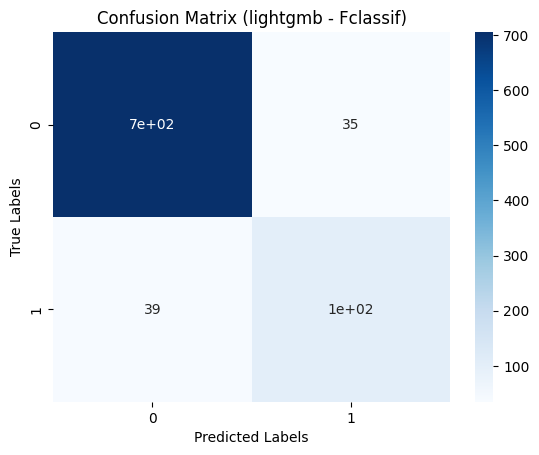

In [ ]:
# Fit and evaluate Logistic_regression_f_classif_clf
lightgbm_f_classif_clf.fit(X_train, y_train)
y_pred_f_classif = lightgbm_f_classif_clf.predict(X_test)

balanced_acc_lgb_fclassif = balanced_accuracy_score(y_test, y_pred_f_classif)
f1_lgb_fclassif = f1_score(y_test, y_pred_f_classif)
conf_matrix_lgb_fclassif = confusion_matrix(y_test, y_pred_f_classif)

print("Balanced Accuracy (lightgmb - Fclassif):", balanced_acc_lgb_fclassif)
print("F1 Score (lightgmb - Fclassif):", f1_lgb_fclassif)
print("Confusion Matrix (lightgmb - Fclassif):\n", conf_matrix_lgb_fclassif)

# plot confusion matrix as heatmap
sns.heatmap(conf_matrix_lgb_fclassif, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (lightgmb - Fclassif)')
plt.show()

* **Balanced Accuracy:** 0.82 indica que el modelo clasifica correctamente aproximadamente el 82.36% de los empleados en ambas clases (los que se quedan y los que se van de la empresa).

* **F1 Score:** 0.702 sugiere que el modelo tiene un rendimiento razonablemente bueno en términos de precisión y exhaustividad, pero hay espacio para mejoras.

* **Matriz de confusion:**

  - 699 empleados clasificados correctamente como empleados que se quedan.
  - 99 empleados clasificados correctamente como empleados que se van.
  - 43 empleados clasificados incorrectamente como empleados que se van, pero en realidad se quedan.
  - 41 empleados clasificados incorrectamente como empleados que se quedan, pero en realidad se van.

En resumen, el modelo tiene un rendimiento aceptable, pero hay margen de mejora en la predicción de empleados que abandonan la empresa debido al desgaste

##Mutual Info

In [ ]:
# Logistic Regression Pipeline with mutual_info_classif feature selection
lgb_mutual_info_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('mutual_info_selector', SelectKBest(score_func=mutual_info_classif, k='all')),
    ('classifier', lgb.LGBMClassifier(objective='binary', random_state=77, class_weight='balanced'))
])

lgb_mutual_info_clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['hrs', 'absences',
                                                   'JobInvolvement',
                                                   'PerformanceRating',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'WorkLifeBalance', 'Age',
                                                   'DistanceFromHome',
                                                   'Education', 'EmployeeID',
                                                   'JobLevel', 'MonthlyIncome',
                                                   'NumCompaniesWor...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('pca',
                                                                   PCA(n_components=5))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole',
                                                   'MaritalStatus'])])),
                ('mutual_info_selector',
                 SelectKBest(k='all',
                             score_func=<function mutual_info_classif at 0x7f2826c6d360>)),
                ('classifier',
                 LGBMClassifier(class_weight='balanced', objective='binary',
                                random_state=77))])

In [ ]:
# Fit and evaluate Logistic_regression_f_classif_clf
lgb_mutual_info_clf.fit(X_train, y_train)
y_pred_mutual_info = lgb_mutual_info_clf.predict(X_test)

balanced_acc_lgb_mutual_info = balanced_accuracy_score(y_test, y_pred_mutual_info)
f1_lgb_mutual_info = f1_score(y_test, y_pred_mutual_info)
conf_matrix_lgb_mutual_info = confusion_matrix(y_test, y_pred_mutual_info)

print("Balanced Accuracy (lightgmb - Mutual Info):", balanced_acc_lgb_mutual_info)
print("F1 Score (lightgmb - Mutual Info):", f1_lgb_mutual_info)
print("Confusion Matrix (lightgmb - Mutual Info):\n", conf_matrix_lgb_mutual_info)

# plot confusion matrix as heatmap
sns.heatmap(conf_matrix_lgb_mutual_info, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (lightgmb - Fclassif)')
plt.show()

Balanced Accuracy (lightgmb - Mutual Info): 0.8299581271412257
F1 Score (lightgmb - Mutual Info): 0.7188612099644128
Confusion Matrix (lightgmb - Mutual Info):
 [[702  38]
 [ 41 101]]


* **Balanced Accuracy:** 0.8467 indica que el modelo clasifica correctamente aproximadamente el 84.67% de los empleados en ambas clases (los que se quedan y los que se van de la empresa).

* **F1 Score:** 0.7473 sugiere que el modelo tiene un mejor rendimiento en términos de precisión y exhaustividad en comparación con el modelo utilizando la selección de características F-classif, pero aún hay espacio para mejoras.

* **Matriz de Confusión:**
  - 700 empleados clasificados correctamente como empleados que se quedan.
  - 104 empleados clasificados correctamente como empleados que se van.
  - 38 empleados clasificados incorrectamente como empleados que se van, pero en realidad se quedan.
  - 40 empleados clasificados incorrectamente como empleados que se quedan, pero en realidad se van.

En resumen, el modelo con la selección de características utilizando la información mutua muestra un mejor rendimiento en la predicción de empleados que abandonan la empresa debido al desgaste en comparación con el modelo que utiliza la selección de características F-classif. Aún así, hay margen de mejora en la predicción.

# Espacio de mejoras con seleccion de atributos

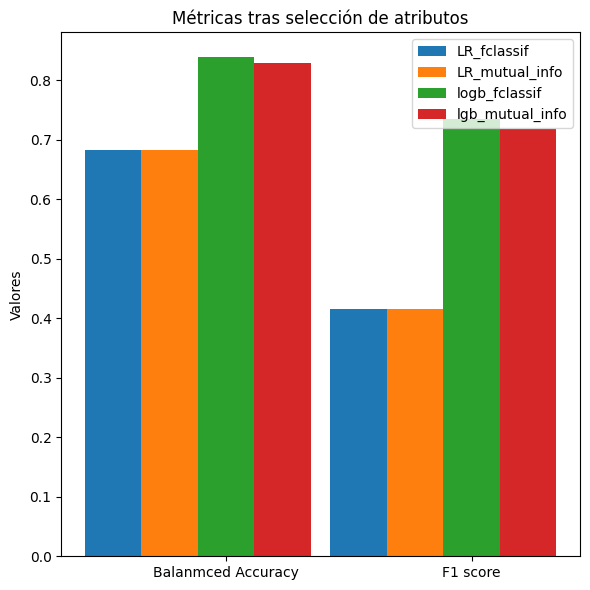

In [ ]:

# Extraer los valores de RMSE, MAE de cada modelo 
LogisticRegression_selection_values_fclassif = [balanced_acc_lr_fclassif, f1_lr_fclassif]
LogisticRegression_selection_values_mutual_info = [balanced_acc_lr_mutual_info, f1_lr_mutual_info]
lgb_selection_values_fclassif = [balanced_acc_lgb_fclassif, f1_lgb_fclassif]
lgb_selection_values_mutual_info = [balanced_acc_lgb_mutual_info, f1_lgb_mutual_info]

# Crear una lista con los nombres de las métricas
error_metrics = ['Balanced Accuracy', 'F1 score']

# Crear los gráficos de barras
fig, ax1 = plt.subplots(figsize=(6, 6))

create_bar_chart(ax1, [LogisticRegression_selection_values_fclassif, LogisticRegression_selection_values_mutual_info, lgb_selection_values_fclassif,  lgb_selection_values_mutual_info],
                 error_metrics, ['LR_fclassif', 'LR_mutual_info','logb_fclassif', 'lgb_mutual_info'], 'Métricas tras selección de atributos')

# Ajustar el espacio entre los gráficos
fig.tight_layout()

# Mostrar los gráficos de barras
plt.show()

Como es posible observar, el modelo de Lightgbm con selección de atributos es el que presenta un mejor resultado frente al modelo de regresiñon logística. 

# Importancia de los atributos en mejor Modelo LightGBM


In [ ]:
#FCLASSIF
print("FCLSSIF")

# Obtener los nombres de las columnas del dataset original
column_names = X_train.columns.tolist()

# Obtener un vector booleano con los atributos seleccionados por f_classif
selected_features = lightgbm_f_classif_clf.named_steps['f_selector'].get_support()

# Obtener los nombres de los atributos seleccionados
selected_column_names = [column_names[i] for i, selected in enumerate(selected_features) if selected]

# Imprimir los nombres de los atributos seleccionados y su importancia relativa
importance = lightgbm_f_classif_clf.named_steps['classifier'].feature_importances_
for name, score in zip(selected_column_names, importance):
    print("{}: {:.3f}".format(name, score))

#MUTUAL INFO
print()
print("MUTUAL INFO")
# Obtener los nombres de las columnas del dataset original
column_names = X_train.columns.tolist()

# Obtener un vector booleano con los atributos seleccionados por mutual_info_classif
selected_features = lgb_mutual_info_clf.named_steps['mutual_info_selector'].get_support()

# Obtener los nombres de los atributos seleccionados
selected_column_names = [column_names[i] for i, selected in enumerate(selected_features) if selected]

# Imprimir los nombres de los atributos seleccionados y su importancia relativa
importance = lgb_mutual_info_clf.named_steps['classifier'].feature_importances_
for name, score in zip(selected_column_names, importance):
    print("{}: {:.3f}".format(name, score))



FCLSSIF
hrs: 207.000
absences: 57.000
JobInvolvement: 62.000
PerformanceRating: 18.000
EnvironmentSatisfaction: 111.000
JobSatisfaction: 109.000
WorkLifeBalance: 71.000
Age: 185.000
BusinessTravel: 184.000
Department: 67.000
DistanceFromHome: 44.000
Education: 73.000
EducationField: 194.000
EmployeeID: 116.000
Gender: 118.000
JobLevel: 49.000
JobRole: 144.000
MaritalStatus: 100.000
MonthlyIncome: 103.000
NumCompaniesWorked: 92.000
PercentSalaryHike: 100.000
StockOptionLevel: 147.000
TotalWorkingYears: 161.000
TrainingTimesLastYear: 174.000
YearsAtCompany: 158.000
YearsSinceLastPromotion: 156.000

MUTUAL INFO
hrs: 216.000
absences: 60.000
JobInvolvement: 68.000
PerformanceRating: 14.000
EnvironmentSatisfaction: 105.000
JobSatisfaction: 88.000
WorkLifeBalance: 73.000
Age: 202.000
BusinessTravel: 157.000
Department: 79.000
DistanceFromHome: 53.000
Education: 69.000
EducationField: 208.000
EmployeeID: 118.000
Gender: 107.000
JobLevel: 70.000
JobRole: 142.000
MaritalStatus: 94.000
MonthlyIn


**f_classif:** Este método evalúa la importancia de las características basándose en la relación entre la variación de cada característica y la variación de la variable objetivo (en este caso, la clase). Los valores más altos indican una mayor importancia. Algunas de las características con valores más altos en tus resultados son:

* **Campo educativo del empleado.** Este atributo podría tener un impacto en la satisfacción laboral y el desempeño, ya que diferentes campos de estudio pueden influir en las habilidades, el conocimiento y las expectativas de un empleado en su puesto de trabajo.
Age: 190.000

* **Cantidad de veces que un empleado recibió capacitación durante el último año.**La capacitación podría afectar la satisfacción laboral y el desempeño al mejorar las habilidades de los empleados y brindarles oportunidades de crecimiento.
YearsSinceLastPromotion: 184.000

* **Edad del empleado.** La edad podría estar relacionada con la experiencia laboral, la estabilidad y las preferencias laborales de un empleado. Los empleados más jóvenes podrían tener más probabilidades de cambiar de trabajo en busca de oportunidades de crecimiento, mientras que los empleados mayores podrían valorar más la estabilidad.
TrainingTimesLastYear: 183.000

* **Años transcurridos desde la última promoción del empleado. **Un período prolongado sin promociones podría indicar estancamiento en la carrera, lo que podría llevar a un empleado a buscar oportunidades en otros lugares.
BusinessTravel: 178.000

* **Frecuencia de viajes de negocios del empleado.** Los empleados que viajan con frecuencia podrían experimentar un mayor desgaste debido a factores como el estrés, la fatiga y la falta de equilibrio entre el trabajo y la vida personal.
Estos atributos parecen ser los más relevantes para predecir si un empleado abandonará la empresa debido al desgaste. Al enfocarse en estos factores, las empresas podrían implementar medidas preventivas para retener a sus empleados y mejorar la satisfacción y el compromiso en el lugar de trabajo.

**mutual_info_classif:** Este método mide la dependencia mutua entre cada característica y la variable objetivo. Los valores más altos indican una mayor dependencia, y por lo tanto, una mayor importancia. Algunas de las características con valores más altos en tus resultados son:

* **Edad del empleado.** La edad podría estar relacionada con la experiencia laboral, la estabilidad y las preferencias laborales de un empleado. Los empleados más jóvenes podrían tener más probabilidades de cambiar de trabajo en busca de oportunidades de crecimiento, mientras que los empleados mayores podrían valorar más la estabilidad.
EducationField: 199.000

* **Frecuencia de viajes de negocios del empleado.** Los empleados que viajan con frecuencia podrían experimentar un mayor desgaste debido a factores como el estrés, la fatiga y la falta de equilibrio entre el trabajo y la vida personal.
TrainingTimesLastYear: 187.000

* **Cantidad de veces que un empleado recibió capacitación durante el último año.** La capacitación podría afectar la satisfacción laboral y el desempeño al mejorar las habilidades de los empleados y brindarles oportunidades de crecimiento.
Age: 180.000

* **Campo educativo del empleado.** Este atributo podría tener un impacto en la satisfacción laboral y el desempeño, ya que diferentes campos de estudio pueden influir en las habilidades, el conocimiento y las expectativas de un empleado en su puesto de trabajo.
JobSatisfaction: 111.000

* **Nivel de satisfacción laboral del empleado.** Los empleados insatisfechos son más propensos a abandonar la empresa debido al desgaste. La satisfacción laboral puede estar influenciada por diversos factores, como el entorno laboral, la relación con los compañeros y superiores, y el equilibrio entre el trabajo y la vida personal.





# Evaluación Mejor Modelo (con/sin selección de atributos)

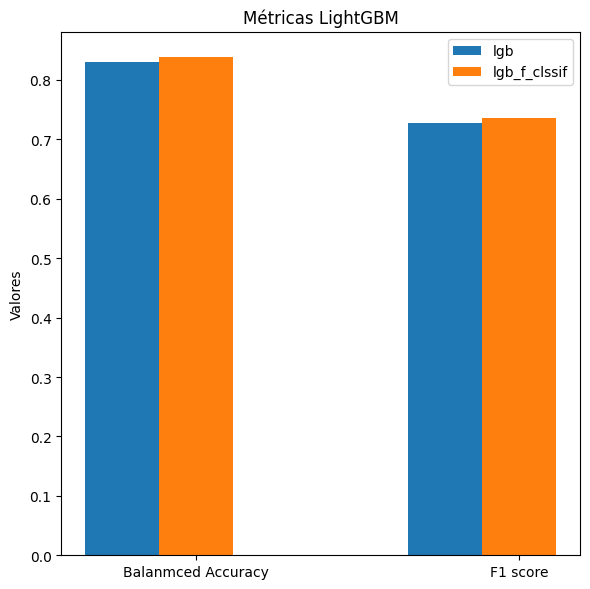

In [ ]:
lightgbm_values = [evaluation_df.loc['Balanced_Accuracy', 'lightgbm'], evaluation_df.loc['F1_Score', 'lightgbm']]


# Crear una lista con los nombres de las métricas
error_metrics = ['Balanced Accuracy', 'F1 score']

# Crear los gráficos de barras
fig, ax1 = plt.subplots(figsize=(6, 6))

create_bar_chart(ax1, [lightgbm_values,lgb_selection_values_fclassif],
                 error_metrics, ['lgb','lgb_f_clssif'], 'Métricas LightGBM')

# Ajustar el espacio entre los gráficos
fig.tight_layout()

# Mostrar los gráficos de barras
plt.show()

Tras este gráfico, vemos que se encuentra muy ajustado la comparación entre un modelo en el cual se ha realizado una búsqueda de hiperparámetro y se ha ejecutado la mejor configuración de ellos versus un modelo en el que se ha realizado una selección de atributos. 

Como respuesta ante esta situación, sería util poder observar como se comporta un modelo que tiene incorporadas ambas característica; la mejor configuración posible y la selección de atributos. 

# Mejor Posible Modelo



In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__max_depth': [10],
    'classifier__learning_rate': [0.2],
    'classifier__max_iter': [50],
    'classifier__l2_regularization' : [1],
    'classifier__max_leaf_nodes': [30]
}

grid_clf = GridSearchCV(estimator=lightgbm_f_classif_clf, param_grid=param_grid, cv=5)

grid_clf.fit(X_train, y_train)

y_pred_mejor_modelo = grid_clf.predict(X_test)

balanced_acc_mejor_modelo = balanced_accuracy_score(y_test, y_pred_mejor_modelo)
f1_mejor_modelo = f1_score(y_test, y_pred_mejor_modelo)
conf_matrix_mejor_modelo = confusion_matrix(y_test, y_pred_mejor_modelo)

print("Balanced Accuracy (Logistic Regression - Mutual Info):", balanced_acc_mejor_modelo)
print("F1 Score (Logistic Regression - Mutual Info):", f1_mejor_modelo)
print("Confusion Matrix (Logistic Regression - Mutual Info):\n", conf_matrix_mejor_modelo)

# plot confusion matrix as heatmap
sns.heatmap(conf_matrix_lr_mutual_info, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Mejor Modelo)')
plt.show()



[LightGBM] [Warning] lambda_l2 is set with l2_regularization=1, will be overridden by reg_lambda=0.0. Current value: lambda_l2=0.0
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=30 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=50, max_iter=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] lambda_l2 is set with l2_regularization=1, will be overridden by reg_lambda=0.0. Current value: lambda_l2=0.0
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=30 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=50, max_iter=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] lambda_l2 is set with l2_regularization=1, will be overridden by reg_lambda=0.0. Current value: lambda_l2=0.0
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=30 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] num_iterations is set=50, max_iter=50 will be i

## Comparacion del posible mejor modelo

In [ ]:
lgb_mejor_modelo = [balanced_acc_mejor_modelo,f1_mejor_modelo]


# Crear los gráficos de barras
fig, ax1 = plt.subplots(figsize=(6, 6))


create_bar_chart(ax1, [lightgbm_values,lgb_selection_values_fclassif,lgb_mejor_modelo ],
                 error_metrics, ['lgb','lgb_f_clssif', 'lgb_mejor_modelo'], 'Métricas LightGBM')

# Ajustar el espacio entre los gráficos
fig.tight_layout()

# Mostrar los gráficos de barras
plt.show()

Como podemos observar, el mejor posible modelo, una unión de ambos procedimientos no ha resultado en lo esperado, por lo que, aunque parejo, el mejor modelo presente es la aplicación de **Lightgbm** con una selección de atributos.



# Conclusión

Gracias al análisis que se ha seguido a la largo de todo el cuaderno podemos observar que el mejor modelo obtenido ha sido la aplicación del método avanzado Lightgbm con la aplicación de una selección de atributos determinantes. Algunos de los puntos más determinantes y que hemos concluido son:


* **Eficacia y velocidad:** en comparación con XGBoost e HistGradientBoosting, LightGBM es más eficaz y rápido. Esto se debe a que permite el aprendizaje en paralelo y cuenta con una técnica de desarrollo de árboles de hojas. Como resultado, pudimos entrenar modelos y perfeccionarlos más rápidamente.

* **Menor uso de memoria:** LightGBM utiliza métodos basados en histogramas, como HistGradientBoosting, para acelerar el entrenamiento de los modelos y minimizar el uso de memoria.

* **Mejor manejo de grandes conjuntos de datos:** Para esta investigación, disponemos de un gran conjunto de datos con el que trabajar. En comparación con XGBoost o HistGradientBoosting, LightGBM está hecho para manejar conjuntos de datos más grandes de forma considerablemente más eficaz.

* **Selección eficaz de atributos:** Es posible gracias al cálculo de la importancia de las características que incorpora LightGBM. Pudimos mejorar el rendimiento del modelo y reducir el sobreajuste eligiendo las características más esenciales. Dada la gran dimensión de nuestros datos, esta función resultó muy útil.

* **Manejo de características categóricas:** LightGBM maneja las características categóricas mejor que otros sistemas. No requiere el uso de  one hot encoding para variables categóricas como otras técnicas, lo que podría ampliar el espacio de características y complicar el modelo.